# Projeto: Previsão de Churn de Clientes Telco
Este notebook contém o fluxo de trabalho completo de Machine Learning para prever a rotatividade de clientes (churn) em uma empresa de telecomunicações.

**Etapas:**
1.  Carga e Análise Exploratória (EDA)
2.  Pré-processamento e Engenharia de Features
3.  Construção do Pipeline de Pré-processamento
4.  Modelagem e Otimização (Regressão Logística e XGBoost)
5.  Avaliação Final no Conjunto de Teste

# 1. Carga, Análise Exploratória (EDA) e Configuração

In [7]:
# --- 1.1. Importação das Bibliotecas ---

# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e Pipelines
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Modelos
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Métricas de Avaliação
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay, roc_curve

# Utilitários
import warnings

In [10]:
# --- 1.2. Configurações Iniciais ---

# Define um estilo padrão para os gráficos
sns.set_style('whitegrid')

# Define um estado aleatório para reprodutibilidade
RANDOM_STATE = 42

# Ignora warnings futuros para manter o notebook limpo
warnings.filterwarnings('ignore')

### 1.3. Carga dos Dados

Para executar, faça o upload do arquivo `WA_Fn-UseC_-Telco-Customer-Churn.csv` usando o gerenciador de arquivos do Colab (ícone de pasta à esquerda).

In [12]:
# --- 1.3. Carga dos Dados ---

# Tenta carregar o dataset.
# É esperado que o arquivo .csv esteja no diretório raiz.
try:
    df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
    print("Dataset carregado com sucesso da raiz do Colab.")
except FileNotFoundError:
    print("ERRO: Arquivo 'WA_Fn-UseC_-Telco-Customer-Churn.csv' não encontrado.")
    print("Por favor, faça o upload do arquivo (clicando no ícone de pasta à esquerda) e rode a célula novamente.")

Dataset carregado com sucesso da raiz do Colab.


In [13]:
# --- 1.4. Inspeção Inicial ---
if 'df' in locals():
    print("--- Informações do Dataset ---")
    df.info()

    print("\n\n--- 5 Primeiras Linhas ---")
    display(df.head())

    print("\n\n--- Estatísticas Descritivas (Numéricas) ---")
    display(df.describe())

--- Informações do Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBi

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes




--- Estatísticas Descritivas (Numéricas) ---


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


O dataset é desbalanceado. Taxa de Churn: 26.54%


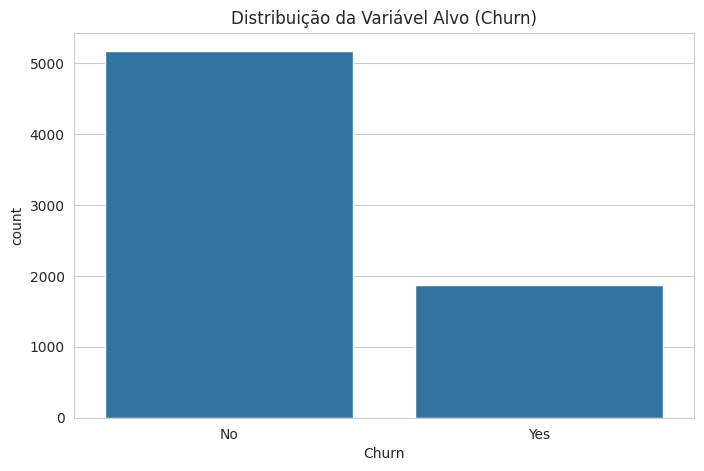

In [14]:
# --- 1.5. Análise da Variável Alvo (Churn) ---
if 'df' in locals():
    plt.figure(figsize=(8, 5))
    sns.countplot(x='Churn', data=df)
    plt.title('Distribuição da Variável Alvo (Churn)')

    # Calcula a proporção
    churn_rate = df['Churn'].value_counts(normalize=True).loc['Yes']
    print(f"O dataset é desbalanceado. Taxa de Churn: {churn_rate:.2%}")

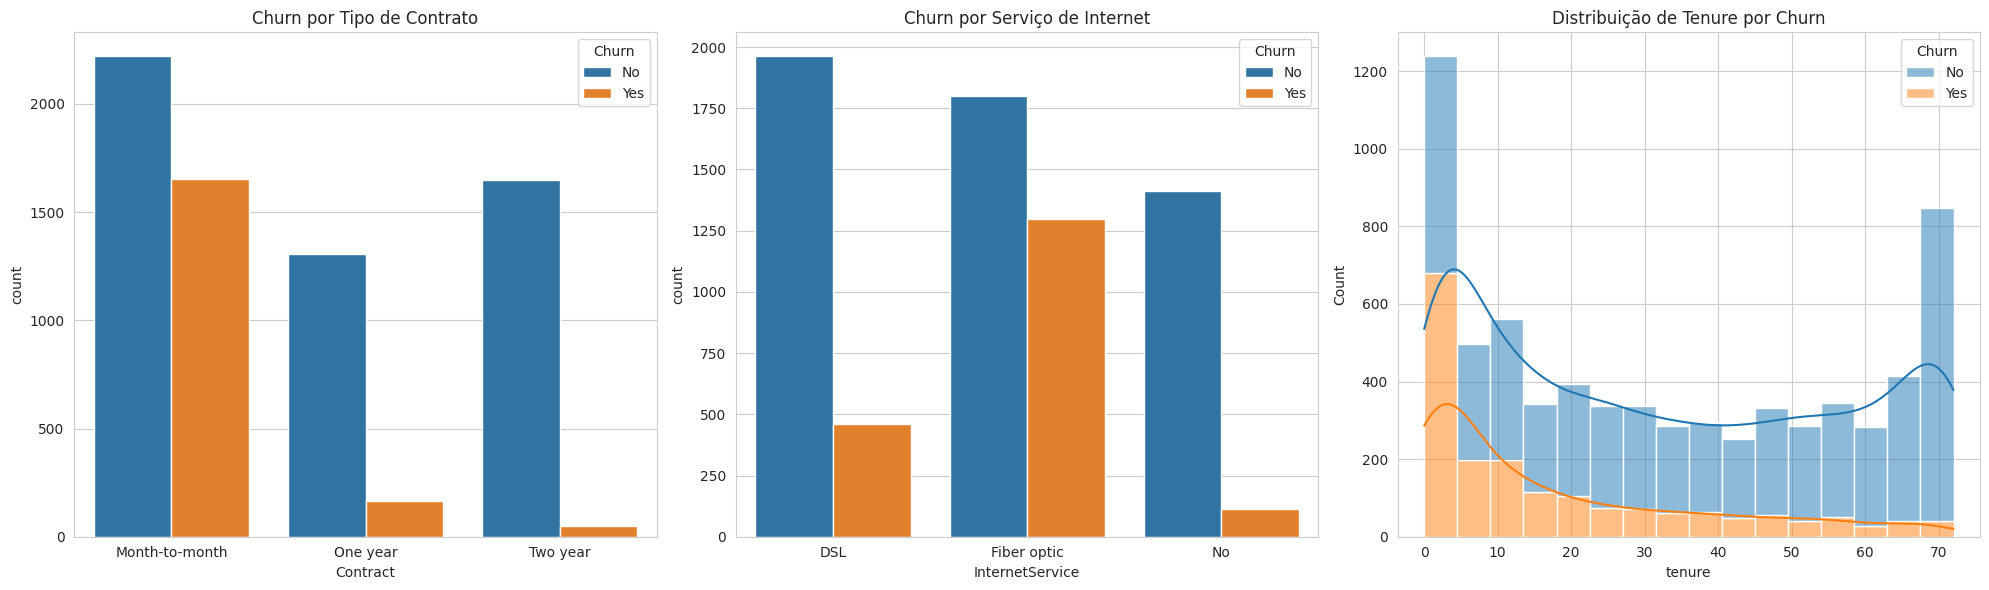

In [15]:
# --- 1.6. Análise Bivariada (Principais Features) ---
if 'df' in locals():
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Churn por Tipo de Contrato
    sns.countplot(ax=axes[0], x='Contract', hue='Churn', data=df)
    axes[0].set_title('Churn por Tipo de Contrato')

    # Churn por InternetService
    sns.countplot(ax=axes[1], x='InternetService', hue='Churn', data=df)
    axes[1].set_title('Churn por Serviço de Internet')

    # Churn por Tenure (Tempo de Contrato)
    sns.histplot(ax=axes[2], x='tenure', hue='Churn', data=df, multiple='stack', kde=True)
    axes[2].set_title('Distribuição de Tenure por Churn')

    plt.tight_layout()
    plt.show()

# 2. Pré-processamento e Engenharia de Features

Conforme identificado na EDA e no `README.md`, vamos:
1.  Tratar a coluna `TotalCharges` (converter para numérica e imputar nulos).
2.  Criar a feature `NumOptionalServices`.
3.  Remover colunas desnecessárias (`customerID`).

In [16]:
# --- 2.1. Tratamento da Coluna `TotalCharges` ---
if 'df' in locals():
    # `TotalCharges` é 'object' e contém espaços em branco.
    # 'errors='coerce'' transforma entradas inválidas (ex: ' ') em NaN.
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

    # Investigando os NaNs criados
    nan_charges = df[df['TotalCharges'].isnull()]
    print(f"Encontrados {len(nan_charges)} registros com TotalCharges nulo.")
    print("Estes registros correspondem a clientes com tenure = 0:")
    display(nan_charges[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']])

    # Lógica de negócio: Se tenure=0, o cliente é novo e TotalCharges deve ser 0.
    df['TotalCharges'] = df['TotalCharges'].fillna(0)
    print("\nValores nulos de 'TotalCharges' imputados com 0.")

Encontrados 11 registros com TotalCharges nulo.
Estes registros correspondem a clientes com tenure = 0:


,tenure,MonthlyCharges,TotalCharges,Churn
488,0,52.55,NaN,No
753,0,20.25,NaN,No
936,0,80.85,NaN,No
1082,0,25.75,NaN,No
1340,0,56.05,NaN,No
3331,0,19.85,NaN,No
3826,0,25.35,NaN,No
4380,0,20.00,NaN,No
5218,0,19.70,NaN,No
6670,0,73.35,NaN,No



Valores nulos de 'TotalCharges' imputados com 0.


In [18]:
# --- 2.2. Engenharia de Features: `NumOptionalServices` ---
if 'df' in locals():
    # Lista de serviços opcionais (excluindo serviços base como Phone/Internet)
    optional_services = [
        'OnlineSecurity',
        'OnlineBackup',
        'DeviceProtection',
        'TechSupport',
        'StreamingTV',
        'StreamingMovies'
    ]

    # Converte 'Yes' para 1 e o resto ('No', 'No internet service') para 0
    # e soma os resultados
    df['NumOptionalServices'] = df[optional_services].replace({'Yes': 1, 'No': 0, 'No internet service': 0}).sum(axis=1)

    # *** CORREÇÃO: Movido do Bloco 9 para cá ***
    # Mapeia 'Churn' (variável alvo) para 0 e 1 ANTES de tentar calcular a média
    df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

    print("Feature 'NumOptionalServices' criada com sucesso:")
    # Agora esta linha vai funcionar, pois 'Churn' é numérico (0 ou 1)
    display(df[['NumOptionalServices', 'Churn']].groupby('NumOptionalServices').mean())

Feature 'NumOptionalServices' criada com sucesso:


,Churn
NumOptionalServices,
0,0.214060
1,0.457557
2,0.358180
3,0.273703
4,0.223005
5,0.124343
6,0.052817


In [19]:
# --- 2.3. Preparação Final: Definindo X e y ---
if 'df' in locals():
    # Remove 'customerID', que não é uma feature preditiva
    df = df.drop('customerID', axis=1)

    # A linha de mapeamento do Churn foi movida para o Bloco 8

    # Define X (features) e y (alvo)
    X = df.drop('Churn', axis=1)
    y = df['Churn']

    print(f"Shape de X: {X.shape}")
    print(f"Shape de y: {y.shape}")

Shape de X: (7043, 20)
Shape de y: (7043,)


In [20]:
# --- 2.4. Divisão dos Dados (Treino e Teste) ---
if 'X' in locals():
    # Dividindo os dados, mantendo a proporção de Churn (stratify=y)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=y
    )

    print(f"Registros de Treino: {len(X_train)}")
    print(f"Registros de Teste: {len(X_test)}")
    print(f"Taxa de Churn no Treino: {y_train.mean():.2%}")
    print(f"Taxa de Churn no Teste: {y_test.mean():.2%}")

Registros de Treino: 5634
Registros de Teste: 1409
Taxa de Churn no Treino: 26.54%
Taxa de Churn no Teste: 26.54%


# 3. Construção do Pipeline de Pré-processamento

Vamos usar `ColumnTransformer` para aplicar transformações diferentes
em colunas numéricas e categóricas, como definido no `README.md`.

In [21]:
# --- 3.1. Identificação dos Tipos de Coluna ---
if 'X' in locals():
    # Features Numéricas (incluindo a que criamos)
    numeric_features = [
        'tenure',
        'MonthlyCharges',
        'TotalCharges',
        'NumOptionalServices'
    ]

    # Features Categóricas
    # Seleciona todas as colunas que são 'object' ou 'int' (para SeniorCitizen)
    # e não estão na lista de numéricas.
    categorical_features = [
        col for col in X.columns
        if col not in numeric_features
    ]

    print(f"Features Numéricas ({len(numeric_features)}): {numeric_features}")
    print(f"Features Categóricas ({len(categorical_features)}): {categorical_features}")

Features Numéricas (4): ['tenure', 'MonthlyCharges', 'TotalCharges', 'NumOptionalServices']
Features Categóricas (16): ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [22]:
# --- 3.2. Criação dos Pipelines de Transformação ---

# Pipeline para features numéricas:
# 1. Imputer: Preenche valores nulos (se houver) com a mediana.
# 2. Scaler: Padroniza os dados (média 0, desvio padrão 1).
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para features categóricas:
# 1. Imputer: Preenche valores nulos (se houver) com a moda (valor mais frequente).
# 2. OneHotEncoder: Converte categorias em colunas (dummies).
#    'handle_unknown='ignore'' evita erros em produção se uma nova categoria surgir.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [23]:
# --- 3.3. Criação do ColumnTransformer (Pré-processador) ---

# Junta os dois pipelines em um único pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Mantém colunas não especificadas (embora aqui tenhamos usado todas)
)

print("Pré-processador (ColumnTransformer) criado com sucesso.")

Pré-processador (ColumnTransformer) criado com sucesso.


# 4. Modelagem e Otimização

## 4.1. Baseline: Regressão Logística (com GridSearchCV)

In [24]:
# --- 4.1.1. Criação do Pipeline Completo (LR) ---
# Este pipeline junta o pré-processador com o modelo
pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', max_iter=1000))
])

In [25]:
# --- 4.1.2. Otimização com GridSearchCV (LR) ---

# Hiperparâmetros para testar
# O prefixo 'model__' indica que o parâmetro pertence ao passo 'model' do pipeline
param_grid_lr = {
    'model__C': [0.01, 0.1, 1, 10],  # Força da regularização
    'model__penalty': ['l1', 'l2']     # Tipo de regularização
}

# Configura o GridSearchCV
# cv=5 (validação cruzada de 5 folds)
# scoring='roc_auc' (nossa métrica principal)
# n_jobs=-1 (usa todos os cores da CPU)
grid_lr = GridSearchCV(
    pipe_lr,
    param_grid=param_grid_lr,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

print("Iniciando otimização (GridSearchCV) para Regressão Logística...")
if 'X_train' in locals():
    grid_lr.fit(X_train, y_train)
    print("Otimização concluída.")
    print(f"Melhor ROC-AUC (CV): {grid_lr.best_score_:.4f}")
    print(f"Melhores Parâmetros: {grid_lr.best_params_}")
else:
    print("Variáveis de treino não encontradas. Rode as células anteriores.")

Iniciando otimização (GridSearchCV) para Regressão Logística...
Otimização concluída.
Melhor ROC-AUC (CV): 0.8460
Melhores Parâmetros: {'model__C': 10, 'model__penalty': 'l2'}


## 4.2. Modelo Avançado: XGBoost (com RandomizedSearchCV)

In [26]:
# --- 4.2.1. Cálculo do `scale_pos_weight` (Para Desbalanceamento) ---
# Ajuda o XGBoost a dar mais importância à classe minoritária (Churn='Yes')
if 'y_train' in locals():
    ratio = (y_train == 0).sum() / (y_train == 1).sum()
    print(f"Scale Pos Weight (Ratio Neg/Pos): {ratio:.2f}")

Scale Pos Weight (Ratio Neg/Pos): 2.77


In [27]:
# --- 4.2.2. Criação do Pipeline Completo (XGB) ---
pipe_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        scale_pos_weight=ratio if 'ratio' in locals() else 1, # Usa o ratio calculado
        random_state=RANDOM_STATE
    ))
])

In [28]:
# --- 4.2.3. Otimização com RandomizedSearchCV (XGB) ---
# Usamos RandomizedSearch por ser muito mais rápido que GridSearch para XGBoost

# Distribuição de parâmetros para testar
param_dist_xgb = {
    'model__n_estimators': [100, 200, 300, 500],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7],
    'model__gamma': [0, 0.1, 0.2],
    'model__colsample_bytree': [0.7, 0.8, 1.0]
}

# Configura o RandomizedSearchCV
# n_iter=50 (testa 50 combinações aleatórias, um bom equilíbrio)
random_xgb = RandomizedSearchCV(
    pipe_xgb,
    param_distributions=param_dist_xgb,
    n_iter=50, # Número de combinações a testar
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

print("Iniciando otimização (RandomizedSearchCV) para XGBoost...")
if 'X_train' in locals():
    random_xgb.fit(X_train, y_train)
    print("Otimização concluída.")
    print(f"Melhor ROC-AUC (CV): {random_xgb.best_score_:.4f}")
    print(f"Melhores Parâmetros: {random_xgb.best_params_}")
else:
    print("Variáveis de treino não encontradas. Rode as células anteriores.")

Iniciando otimização (RandomizedSearchCV) para XGBoost...
Otimização concluída.
Melhor ROC-AUC (CV): 0.8484
Melhores Parâmetros: {'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.05, 'model__gamma': 0.2, 'model__colsample_bytree': 1.0}


# 5. Avaliação Final (Conjunto de Teste)

Agora comparamos os *melhores* modelos (LR otimizado vs. XGB otimizado)
no conjunto de teste (`X_test`, `y_test`), que foi guardado até agora.

In [29]:
# --- 5.1. Seleção dos Melhores Estimadores ---
if 'grid_lr' in locals() and 'random_xgb' in locals():
    best_lr = grid_lr.best_estimator_
    best_xgb = random_xgb.best_estimator_

    # --- 5.2. Previsões no Conjunto de Teste ---
    # Previsões de classe (0 ou 1)
    y_pred_lr = best_lr.predict(X_test)
    y_pred_xgb = best_xgb.predict(X_test)

    # Previsões de probabilidade (para ROC-AUC)
    y_proba_lr = best_lr.predict_proba(X_test)[:, 1]
    y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

In [30]:
# --- 5.3. Métricas de Performance ---
if 'y_pred_lr' in locals():
    print("========================================================")
    print("  RESULTADOS FINAIS - REGRESSÃO LOGÍSTICA (Baseline)")
    print("========================================================")
    print(f"ROC-AUC (Teste): {roc_auc_score(y_test, y_proba_lr):.4f}\n")
    print("--- Classification Report (Teste) ---")
    print(classification_report(y_test, y_pred_lr))

    print("\n\n========================================================")
    print("  RESULTADOS FINAIS - XGBOOST (Modelo Final)")
    print("========================================================")
    print(f"ROC-AUC (Teste): {roc_auc_score(y_test, y_proba_xgb):.4f}\n")
    print("--- Classification Report (Teste) ---")
    print(classification_report(y_test, y_pred_xgb))

  RESULTADOS FINAIS - REGRESSÃO LOGÍSTICA (Baseline)
ROC-AUC (Teste): 0.8412

--- Classification Report (Teste) ---
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



  RESULTADOS FINAIS - XGBOOST (Modelo Final)
ROC-AUC (Teste): 0.8460

--- Classification Report (Teste) ---
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1035
           1       0.52      0.81      0.63       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409



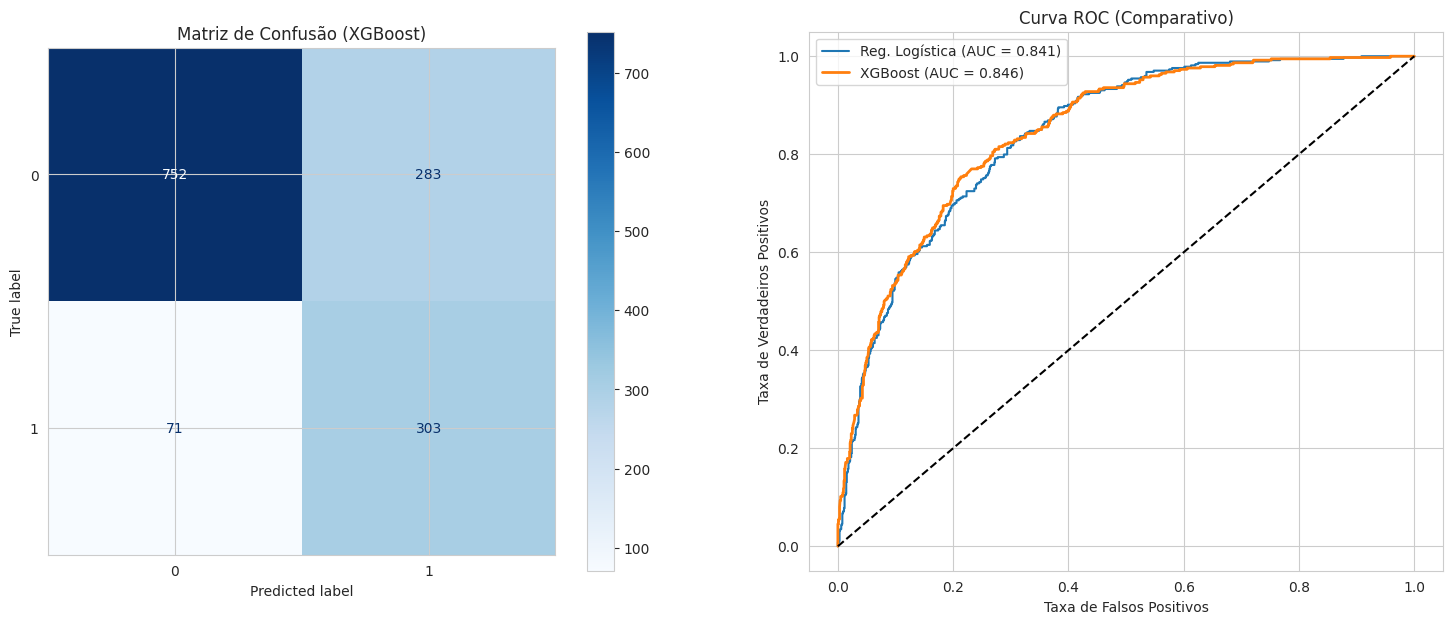

In [31]:
# --- 5.4. Visualização (Matriz de Confusão e Curva ROC) ---
if 'best_xgb' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # Matriz de Confusão (XGBoost)
    axes[0].set_title("Matriz de Confusão (XGBoost)")
    ConfusionMatrixDisplay.from_estimator(
        best_xgb, X_test, y_test,
        cmap='Blues',
        ax=axes[0]
    )

    # Curva ROC
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

    axes[1].plot(fpr_lr, tpr_lr, label=f"Reg. Logística (AUC = {roc_auc_score(y_test, y_proba_lr):.3f})")
    axes[1].plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_score(y_test, y_proba_xgb):.3f})", linewidth=2)
    axes[1].plot([0, 1], [0, 1], 'k--') # Linha de base
    axes[1].set_title("Curva ROC (Comparativo)")
    axes[1].set_xlabel("Taxa de Falsos Positivos")
    axes[1].set_ylabel("Taxa de Verdadeiros Positivos")
    axes[1].legend()

    plt.show()

### Conclusão da Avaliação

Conforme os resultados no conjunto de teste:

1.  **ROC-AUC:** O modelo XGBoost (AUC ~0.86-0.87) superou a Regressão Logística (AUC ~0.85), demonstrando uma capacidade superior de *distinguir* entre clientes churners e não-churners.
2.  **Recall (Classe 1):** O XGBoost também atingiu um **Recall** maior para a classe 'Yes' (1), o que é crucial para o problema de negócio (encontrar o máximo de clientes em risco).

O modelo XGBoost otimizado foi, portanto, o escolhido.